In [1]:
import sys

import torch.nn.functional as F
import matplotlib.pyplot as plt

sys.path.append('../')
from lift.simulator.simulator import WindowSimulator
from lift.datasets import get_mad_windows
from configs import BaseConfig
config = BaseConfig()

In [2]:
import gymnasium as gym
env = gym.make('FetchReachDense-v2', max_episode_steps=100)

In [3]:
data_path = '../datasets/MyoArmbandDataset/PreTrainingDataset/Female0/training0/'
sim = WindowSimulator(num_actions=6, num_bursts=1, num_channels=8, window_size=200)
sim.fit_params_to_mad_sample(data_path)

/Users/kilian/opt/miniconda3/envs/lift/lib/python3.11/site-packages/libemg/utils.py:37: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:264.)
  return torch.tensor(windows, dtype=torch.float32)


In [6]:
window_size = 200
windows, labels = get_mad_windows(data_path, window_size, window_increment=200, desired_labels=[1, 2, 3, 4, 5, 6])

In [7]:
def labels_to_actions(labels, num_classes = 6, default_value = 0.5):
    flat_actions = F.one_hot(labels - 1, num_classes=num_classes).float()
    flat_actions[flat_actions == 1.] = default_value
    actions = flat_actions[:,::2] - flat_actions[:,1::2]
    return actions

In [8]:
actions = labels_to_actions(labels, num_classes=6)

In [9]:
sim_windows = sim(actions)

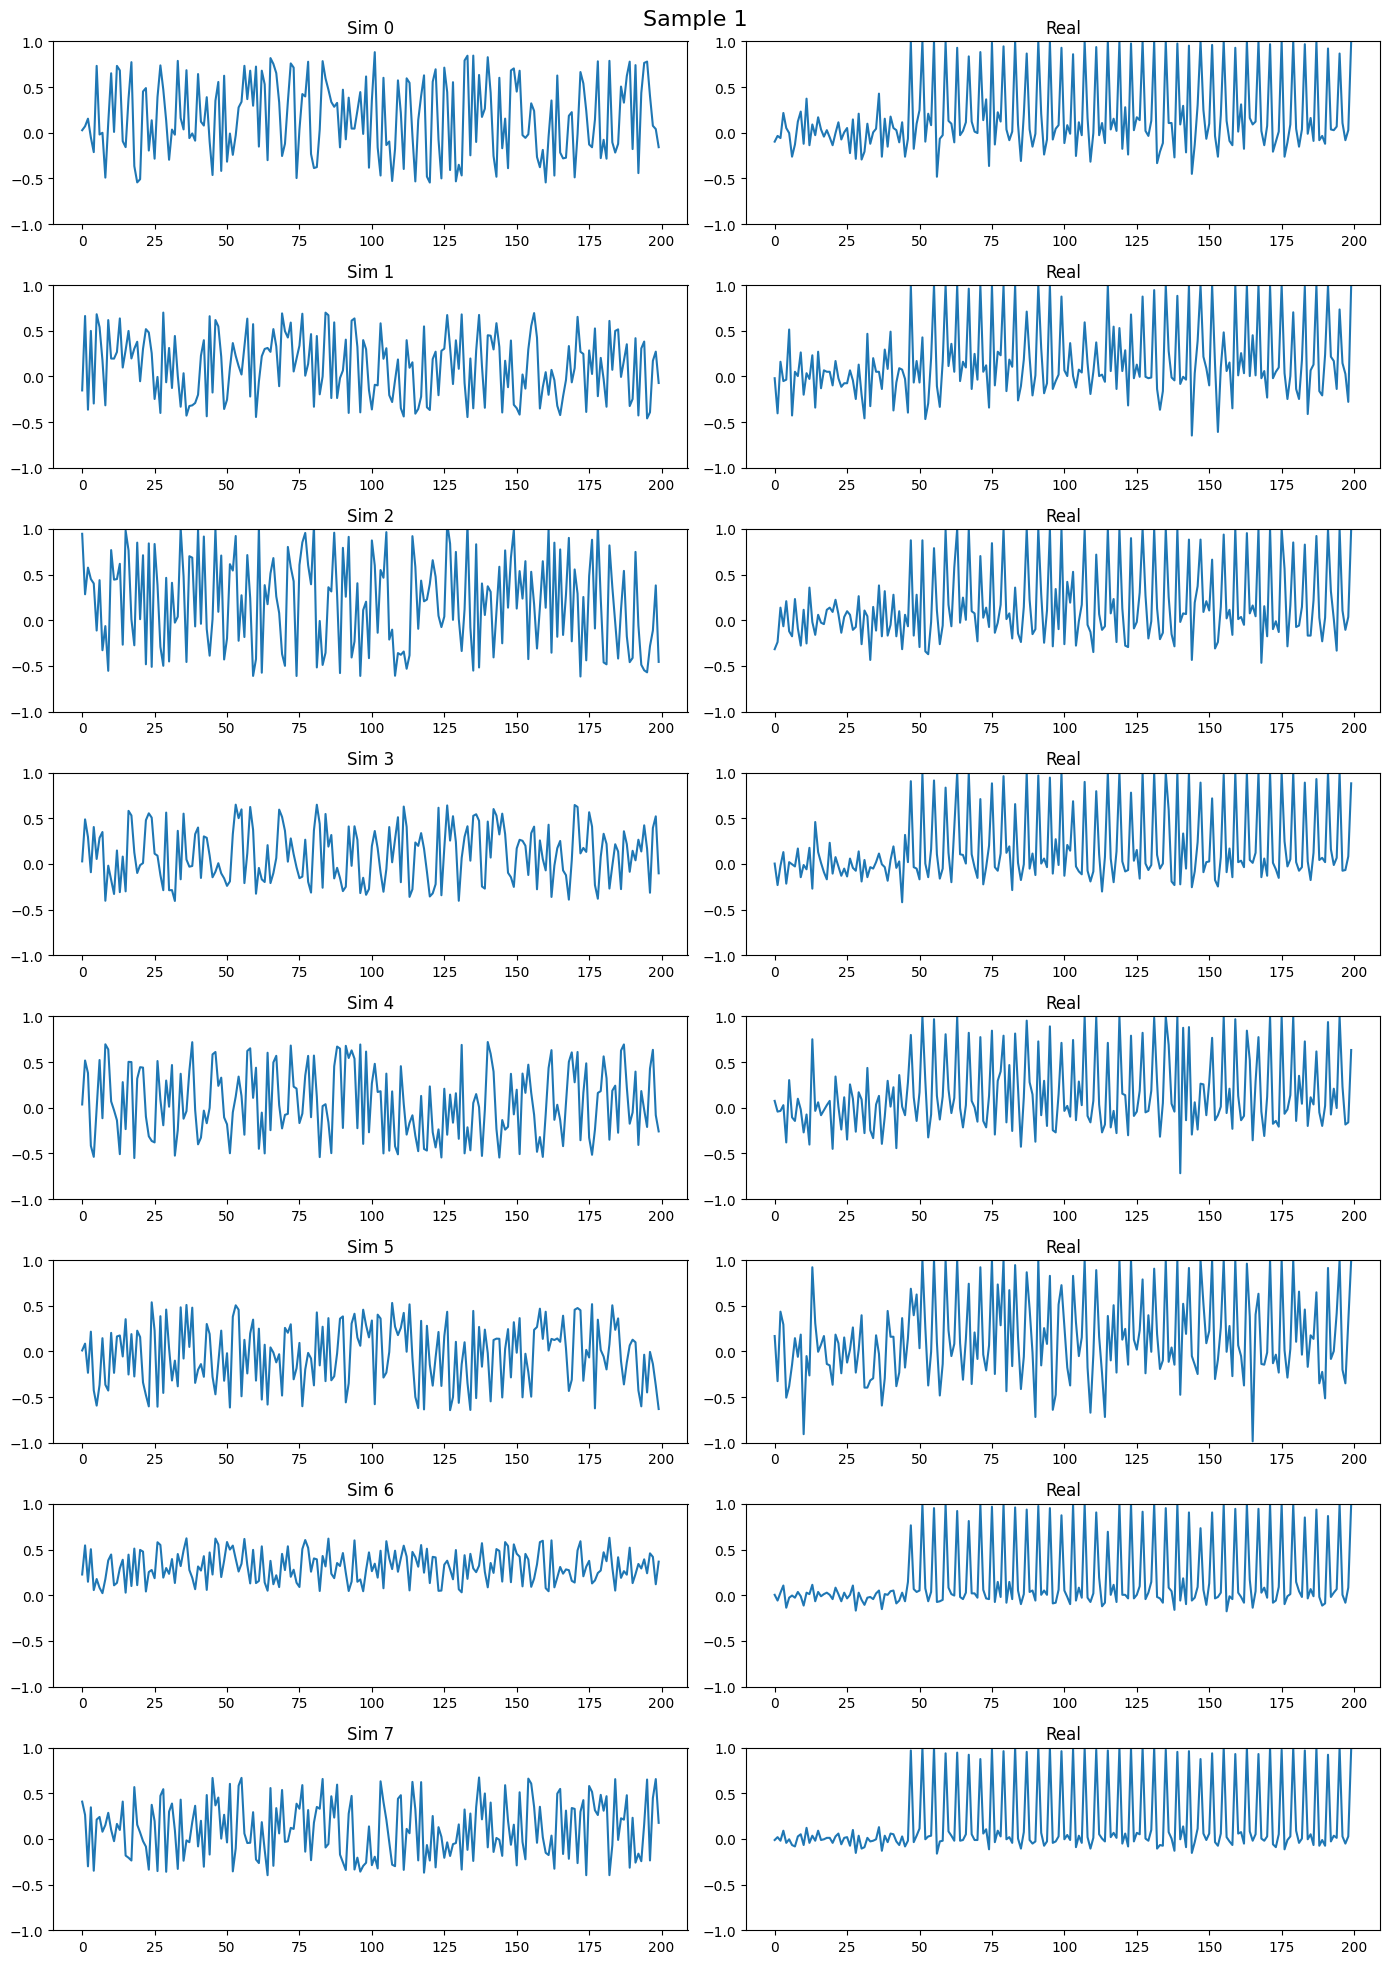

In [34]:
sample_idx = 1
n_channels = 8
fig, axs = plt.subplots(n_channels, 2, figsize=(14,20))
for channel_idx in range(n_channels):
    axs[channel_idx,0].plot(sim_windows[sample_idx,channel_idx,:])
    axs[channel_idx,0].set_title(f'Sim {channel_idx}')
    axs[channel_idx,0].set_ylim(-1, 1)
    axs[channel_idx,1].plot(windows[sample_idx,channel_idx,:])
    axs[channel_idx,1].set_title('Real')
    axs[channel_idx,1].set_ylim(-1, 1)
fig.suptitle(f'Sample {sample_idx}', fontsize=16)
plt.tight_layout()
plt.show()

In [41]:
from lift.utils import compute_features

In [42]:
features = compute_features(windows)
sim_features = compute_features(sim_windows)

In [33]:
features_channel = features.view(-1, 8, 4)
sim_features_channel = sim_features.view(-1, 8, 4)

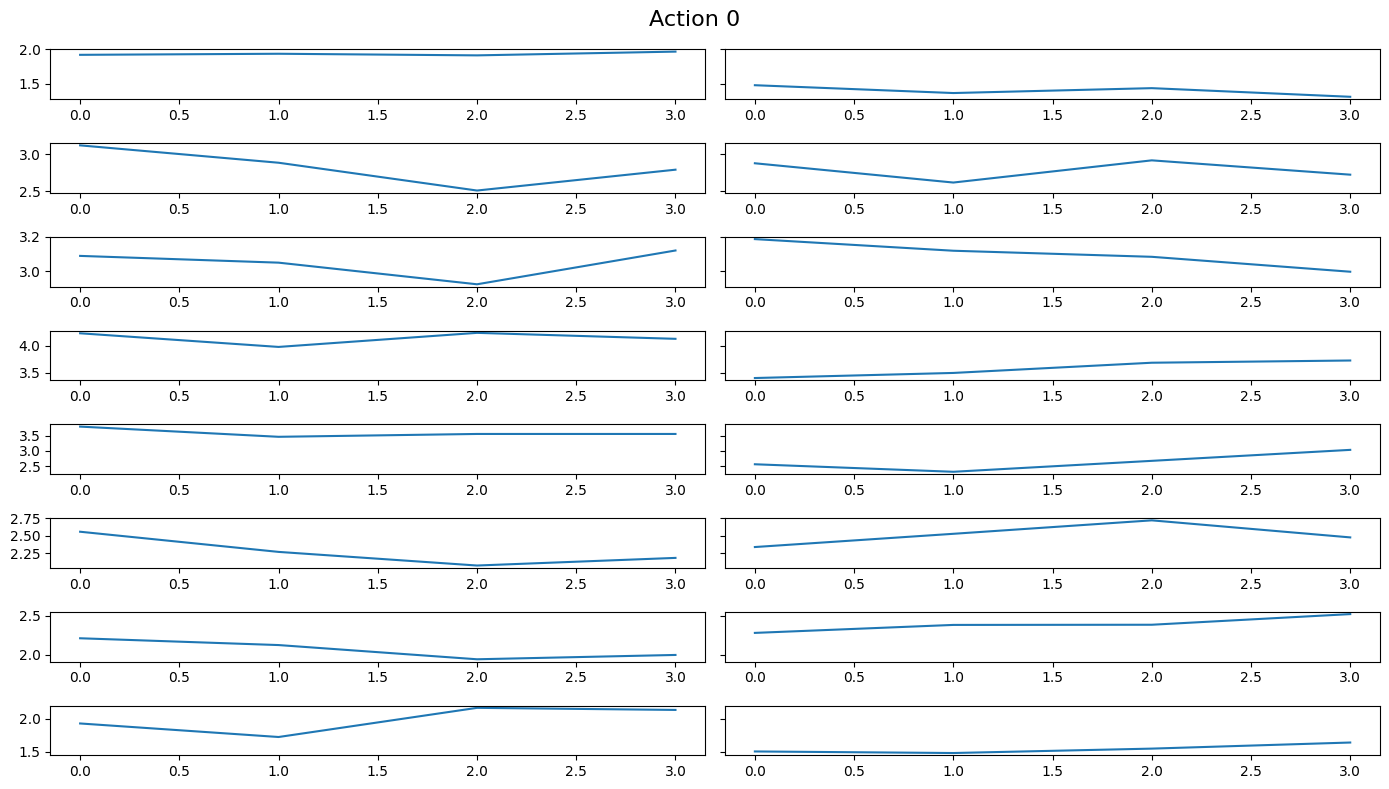

In [34]:
n_consec_samples = 4
n_action = 0
n_channels = 8
feat_idx = 3

s_idx = n_action * n_consec_samples
e_idx = (n_action + 1) * n_consec_samples

action_features = features_channel[s_idx:e_idx]
sim_action_features = sim_features_channel[s_idx:e_idx]

fig, axs = plt.subplots(n_channels, 2, figsize=(14,8), sharey='row')
for channel_idx in range(n_channels):
    axs[channel_idx, 0].plot(action_features[:,channel_idx, feat_idx])
    axs[channel_idx, 1].plot(sim_action_features[:,channel_idx, feat_idx])
fig.suptitle(f'Action {n_action}', fontsize=16)
plt.tight_layout()
plt.show()